# Arch mice notebook - extract ALL information you want

In [98]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook
import nose as nose

from scipy import signal 

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
#for access to google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

import scipy as scipy
import pycircstat as pycircstat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define cutoffs

In [68]:
#       information content          speed      hd       grid     border
#95th    0.9113                     0.2525    0.2253    0.2821    0.4957
#99th    1.914800                   0.3694    0.5025    0.5533    0.6317

In [69]:
# taking the 95th percentiles for now 
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
rate_cutoff = 0.2 

# Retrieve data 


In [70]:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

drive = GoogleDrive(gauth)

file_obj = drive.CreateFile({'id': '1VCDXjyK_tefxNTWo8U3f9AKHFVsxDc9b'})
file_obj.GetContentFile('arch_all.pkl')

arch_all = pd.read_pickle("arch_all.pkl")

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=605130979897-if77ri900jqlssu1hs62hqahsne8pf89.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


# Notebook 1 for reproducing the figures and analysis related to figure 3
Executing this notebook will reproduce the images in figure 3 of our paper and run the corresponding statistical tests described in the text.  

In [71]:
new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_mean_phase_bnt.iloc[i]
    if np.isscalar(mj)== True:
        new_column.append(mj) 
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_mean_phase_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_strength_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_strength_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.calbindin_dist_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['calbindin_dist_bnt_single'] = new_column

## Get total number of tagged cells
This will retrieve all the cells that were tagged in the dataset (see text for criteria)

In [72]:
cells = arch_all[(arch_all.label == 'inhibited')].copy()
inhib_cells = arch_all[(arch_all.label == 'inhibited')].copy()
label = 'Tagged arch\nn={}'.format(len(cells))

In [73]:
print('There are {} in this filtered dataframe. Label: {}'.format(len(cells),label))

There are 82 in this filtered dataframe. Label: Tagged arch
n=82


## Draw stacked bar chart
The following sections draw the stacked bar charts used in Figure 3, first for the tagged cells ("arch_all") and then for the remaining cells. The bar charts have a dark color for cells that fall into one category ("pure") and a lighter color for cells that fall into multiple categories ("mix"). The percentages above the bars give the total number. Note that all "mix" cells are counted in at least 2 categories and therefore the percentages will not sum to 100%. We prefered this represenation of the data to a pie chart (or similar) with different slices for all possible conjunctions (grid x HD, speed X border etc.) because the number of possible combinations is large and makes for a complicated figure.

In [74]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]#note additional criteria for stability
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl_bnt <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [75]:
# find all the class labels for "pure cells" by
# finding non-overlap within indices of other cell classes

pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [76]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len


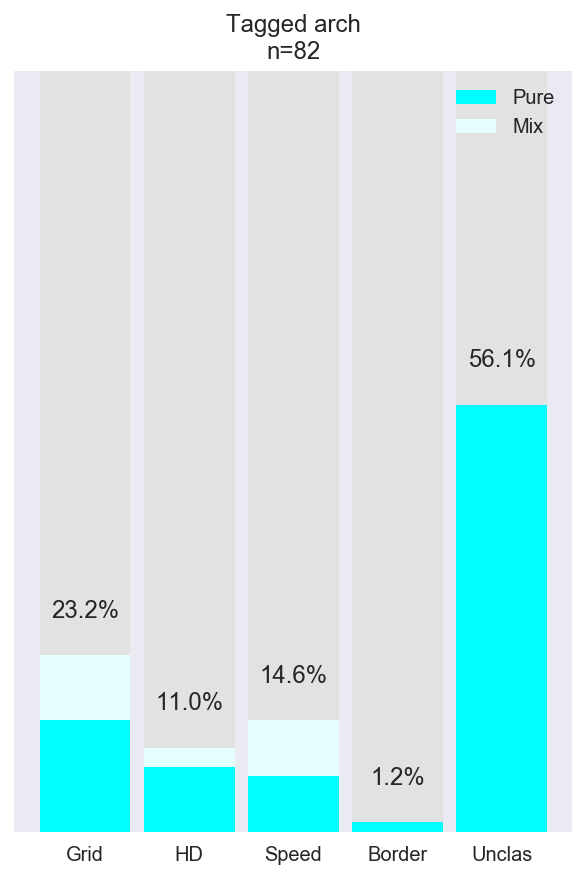

(0.14634146341463414, 0.08536585365853659, 0.07317073170731707, 0.012195121951219513, 0.5609756097560976)


In [77]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("cyan",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Now make the same stacked bar but for all other cells

In [78]:
non_inhib_cells = arch_all[(arch_all.label != 'inhibited')].copy()# retrieves all cells that were not tagged
non_inhib_cells = non_inhib_cells[non_inhib_cells.artefact ==0]
label = 'untagged \nn={}'.format(len(non_inhib_cells))#and labels them

In [79]:
gridc = non_inhib_cells[non_inhib_cells.grid_score_bnt > grid_cutoff]
hdc = non_inhib_cells[(non_inhib_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_inhib_cells.angular_stability_bnt>0.6)]# plus stability
speedc = non_inhib_cells[non_inhib_cells.speedscore_bnt > speed_cutoff]
borderc = non_inhib_cells[non_inhib_cells.borderscore_bnt > border_cutoff]

unclas = non_inhib_cells[(non_inhib_cells.grid_score_bnt <= grid_cutoff) &\
               (non_inhib_cells.tc_stats_mvl_bnt <= mvl_cutoff) &\
               (non_inhib_cells.speedscore_bnt <= speed_cutoff) &\
               (non_inhib_cells.borderscore_bnt <= border_cutoff)]

In [80]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [81]:
all_len = len(non_inhib_cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len

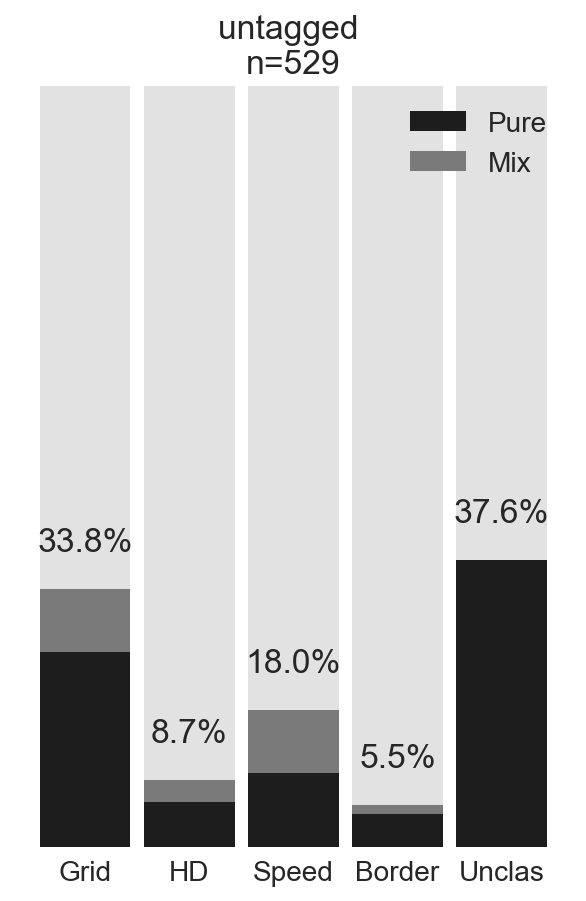

(0.2551984877126654, 0.05860113421550094, 0.09640831758034027, 0.043478260869565216, 0.3761814744801512)


In [82]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()
colors = cm.Greys

sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=colors(0.9))
p2 = plt.bar(ind, mix, width, color=colors(0.6), bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\untagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Compare scores between tagged and untagged populations
The following section will compare the functional properties between tagged and untagged cells.The code is essentially repeated for each variable. The only change is what is being ploted/compared. 


### Look at grid score 

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


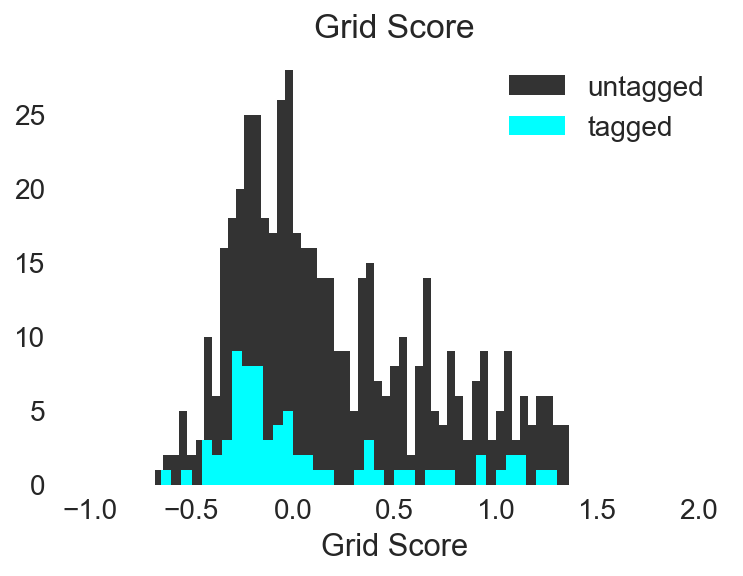

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


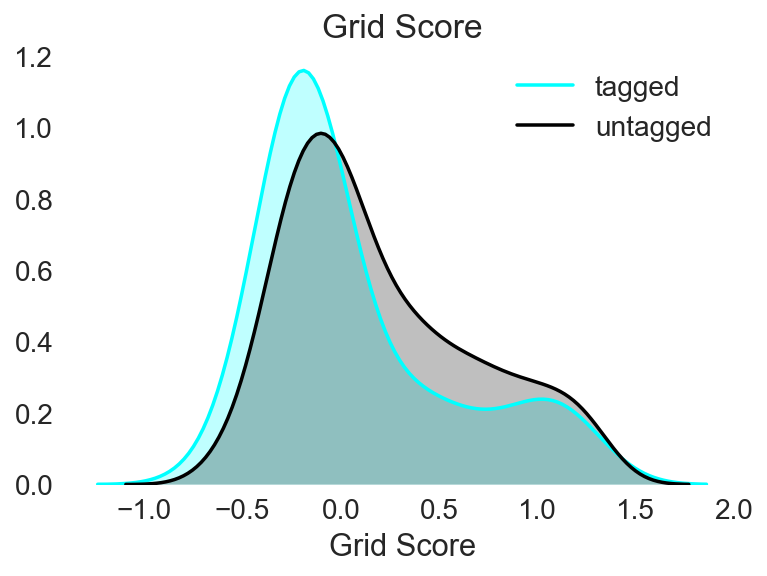

In [83]:
plt.hist(non_inhib_cells.grid_score_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1.4]);
plt.hist(inhib_cells.grid_score_bnt,60,color='cyan',label='tagged',range=[-1, 2]);

sns.despine(left=True,bottom=True)
plt.xlabel('Grid Score')
plt.title('Grid Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_hist.svg', format='svg', dpi=1000)
plt.show()

sns.kdeplot(inhib_cells.grid_score_bnt, shade=True, color="cyan",label='tagged')
sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].grid_score_bnt, shade=True, color="black",label='untagged')
sns.despine(left=True,bottom=True)
 
plt.xlabel('Grid Score')
plt.title('Grid Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [84]:

from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(inhib_cells.grid_score_bnt, non_inhib_cells.grid_score_bnt, alternative = "two-sided")

MannwhitneyuResult(statistic=20525.0, pvalue=0.43406664323327904)

### Look at speed score

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


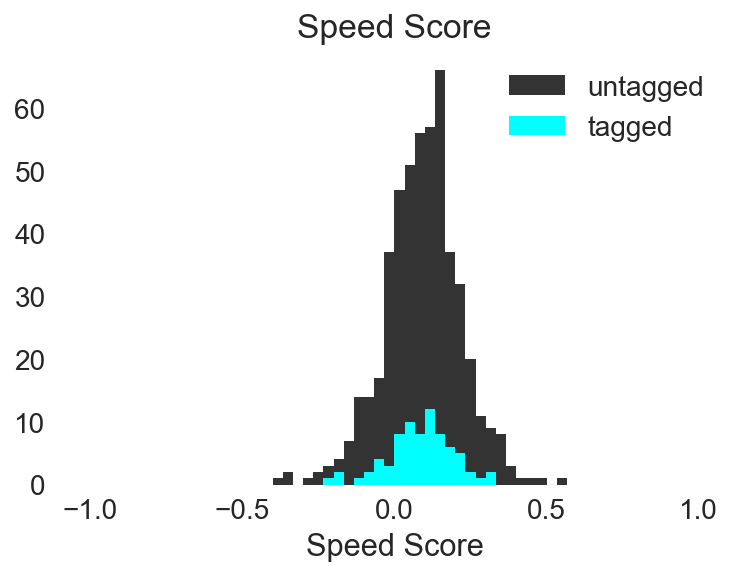

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


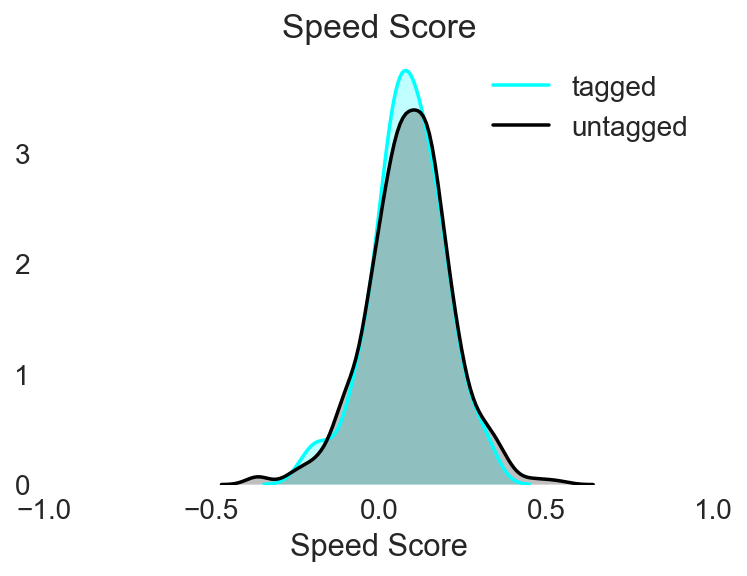

In [85]:
plt.hist(non_inhib_cells.speedscore_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1]);
plt.hist(inhib_cells.speedscore_bnt,60,color='cyan',label='tagged',range=[-1, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Speed Score')
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_hist.svg', format='svg', dpi=1000)
plt.show()

sns.kdeplot(inhib_cells.speedscore_bnt, shade=True, color="cyan",label='tagged')
sns.kdeplot(non_inhib_cells.speedscore_bnt, shade=True, color="black",label='untagged')
sns.despine(left=True,bottom=True)
plt.xlabel('Speed Score')
plt.xlim( (-1, 1) ) 
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [86]:

scipy.stats.mannwhitneyu(inhib_cells.speedscore_bnt, non_inhib_cells.speedscore_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=21782.0, pvalue=0.95041137474809911)

### look at directional tuning

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


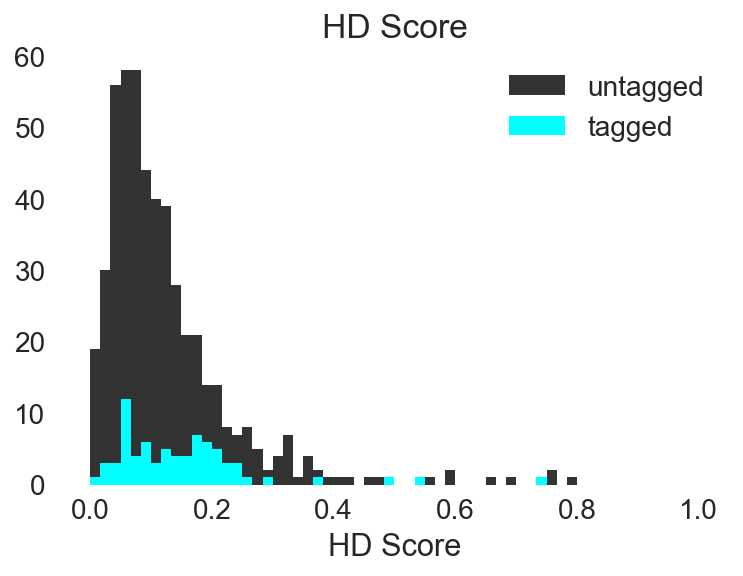

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


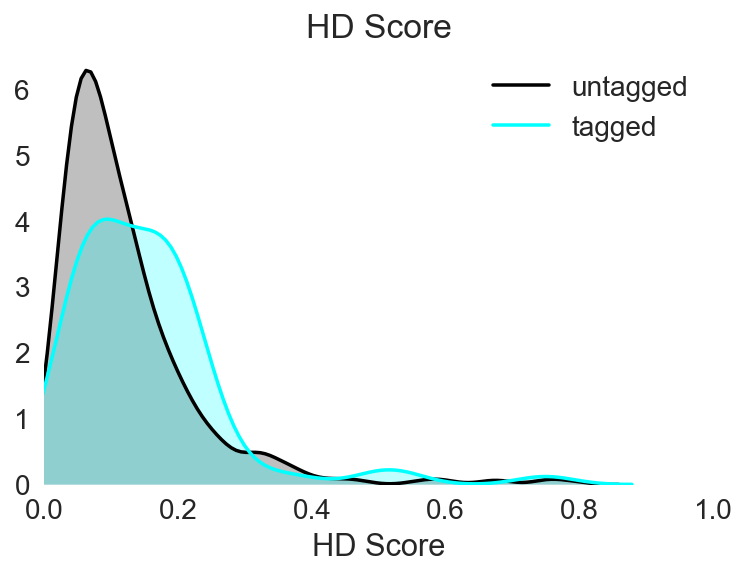

In [87]:
plt.hist(non_inhib_cells.tc_stats_mvl_bnt,60,color='k',label='untagged',alpha=0.8,range=[0, 1]);
plt.hist(inhib_cells.tc_stats_mvl_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('HD Score')
plt.title('HD Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\head_direction_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].tc_stats_mvl_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].tc_stats_mvl_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (0, 1) ) 
plt.xlabel('HD Score')
plt.title('HD Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\head_direction_kde.svg', format='svg', dpi=1000)
plt.show()

In [88]:

scipy.stats.mannwhitneyu(inhib_cells.tc_stats_mvl_bnt, non_inhib_cells.tc_stats_mvl_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=27265.0, pvalue=0.00017785583218827021)

### Look at spatial information 

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


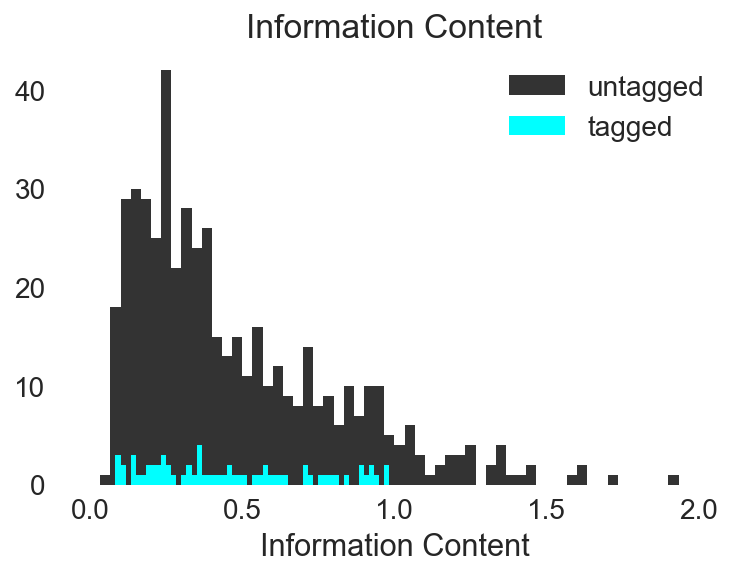

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


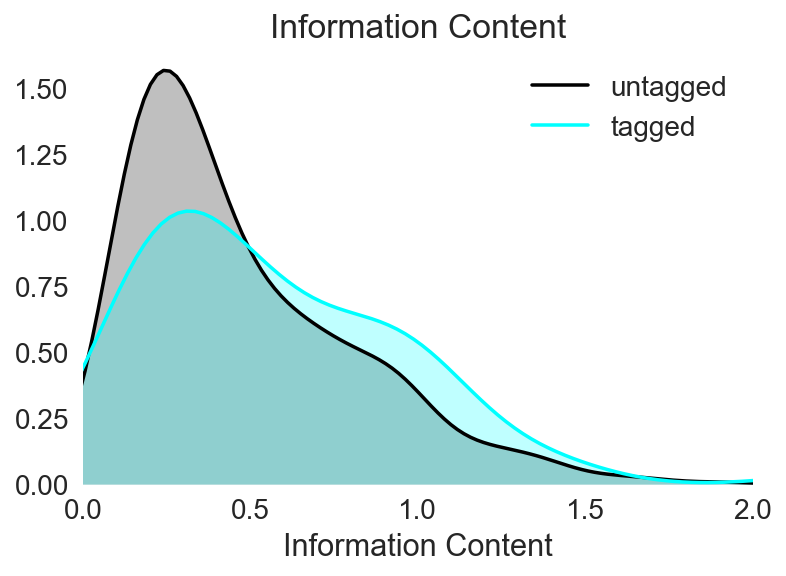

In [89]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].informationcontent_bnt,60,color='k',label='untagged',alpha=0.8,range=[0, 2.0]);
plt.hist(inhib_cells.informationcontent_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Information Content')
plt.title('Information Content')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\spatial_info_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].informationcontent_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].informationcontent_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (0, 2) ) 
plt.xlabel('Information Content')
plt.title('Information Content')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\spatial_info_kde.svg', format='svg', dpi=1000)
plt.show()

In [90]:

scipy.stats.mannwhitneyu(inhib_cells.informationcontent_bnt, non_inhib_cells.informationcontent_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=25238.0, pvalue=0.017044326441154296)

### look at border score

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


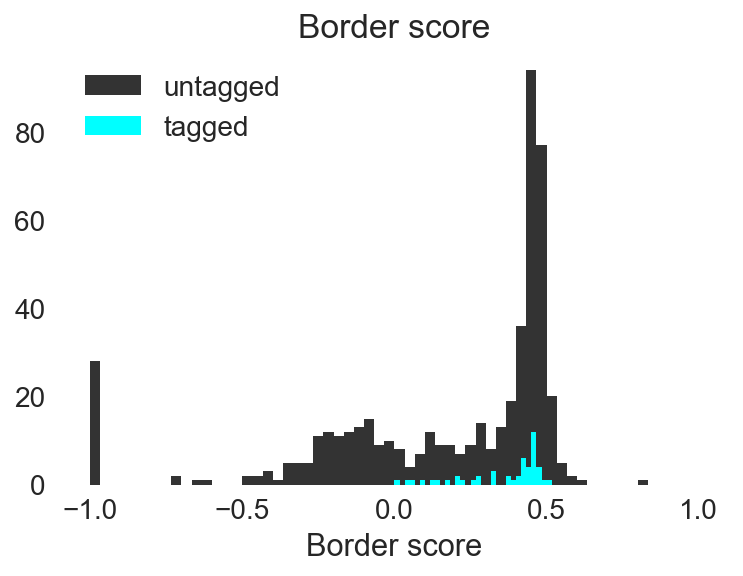

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


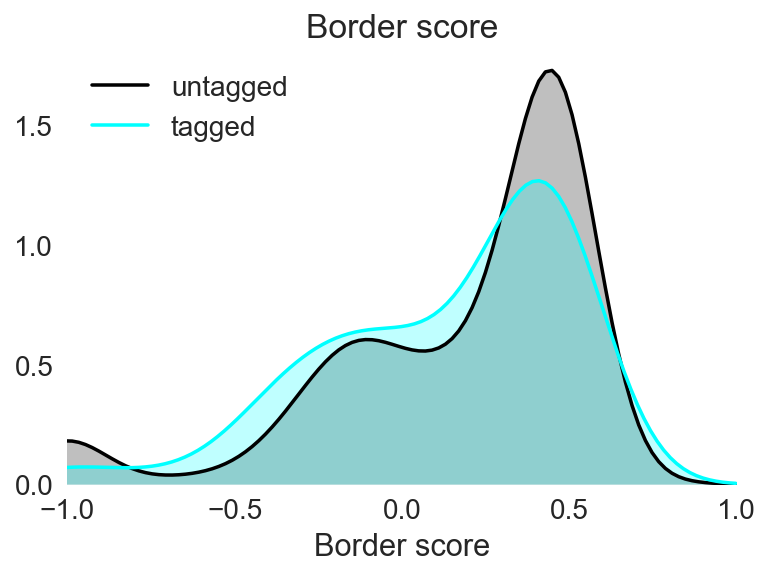

In [91]:
plt.hist(non_inhib_cells.borderscore_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1.0]);
plt.hist(inhib_cells.borderscore_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Border score')
plt.title('Border score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells.borderscore_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(inhib_cells.borderscore_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (-1.0, 1) ) 
plt.xlabel('Border score')
plt.title('Border score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [92]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(inhib_cells.borderscore_bnt, non_inhib_cells.borderscore_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=19909.0, pvalue=0.23153702608807092)

## section for plotting as a violin plot instead

## Make some violin plots for comparison 

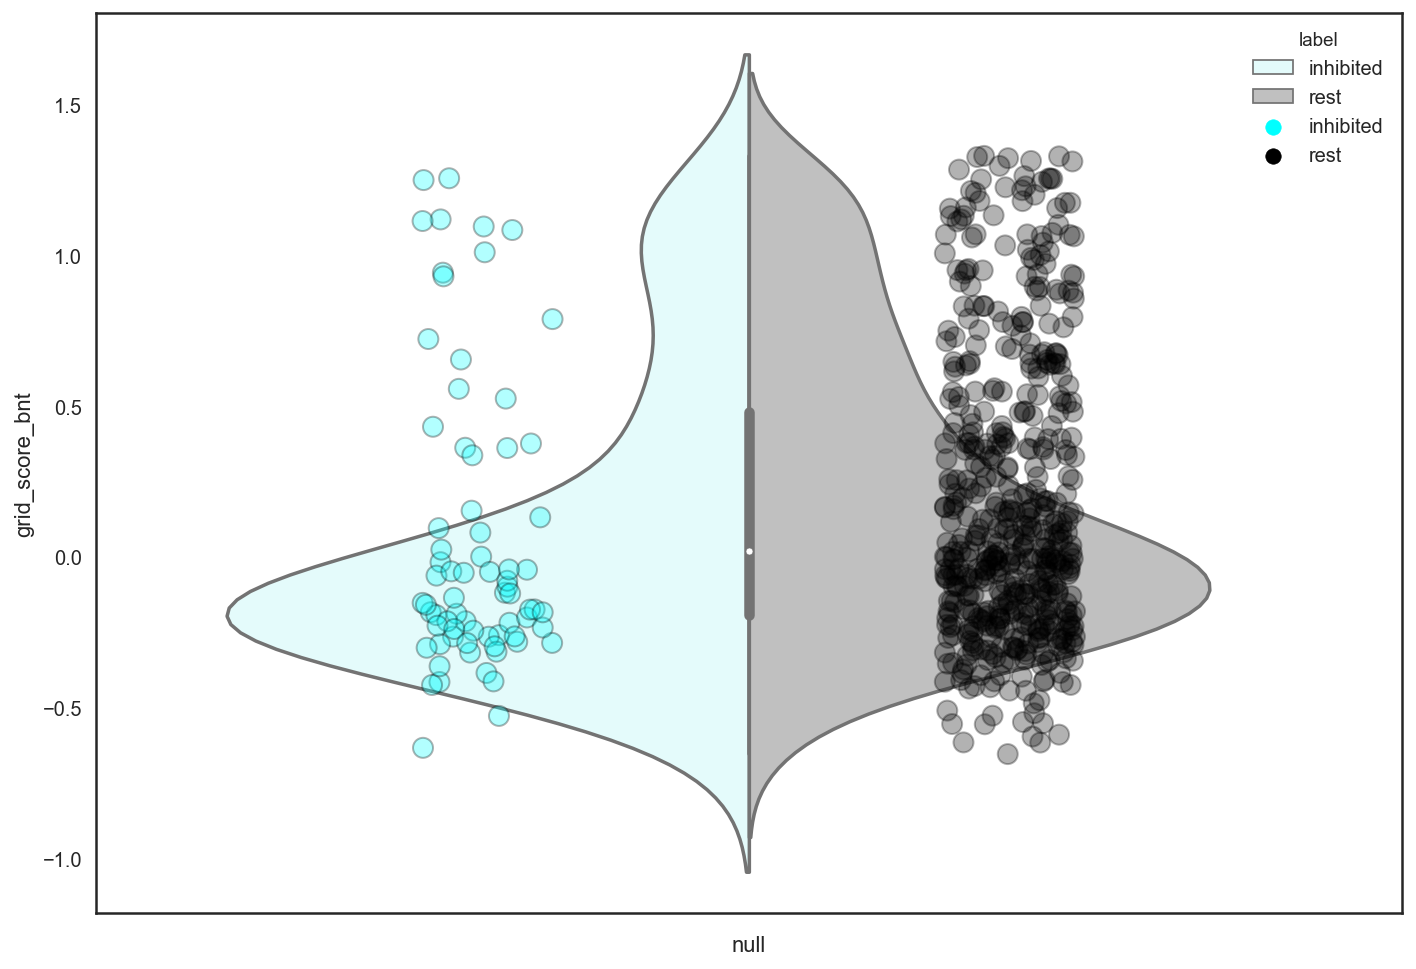

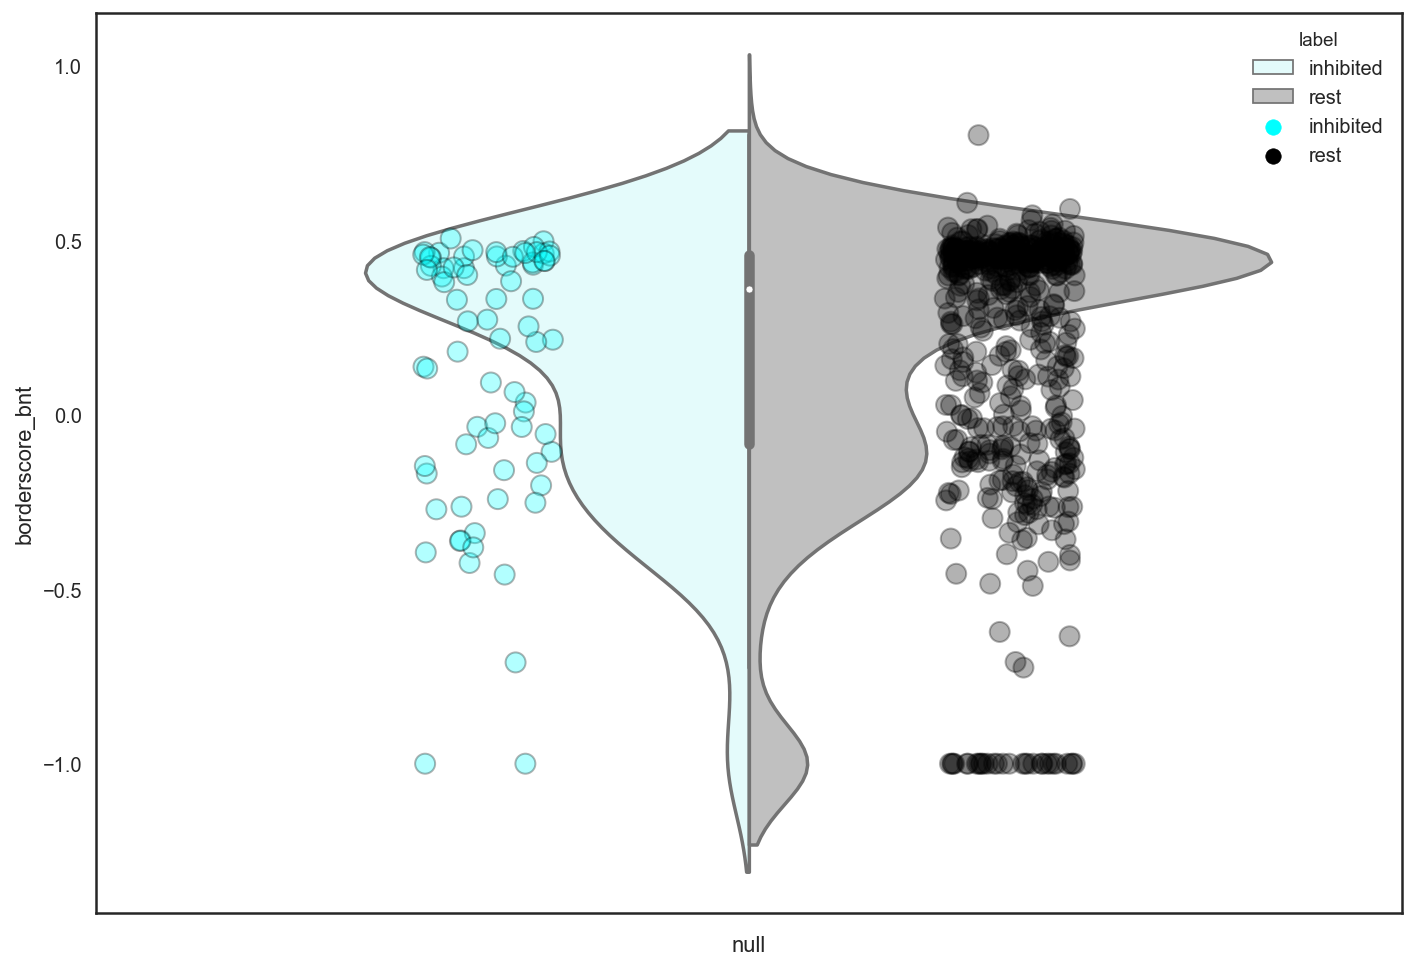

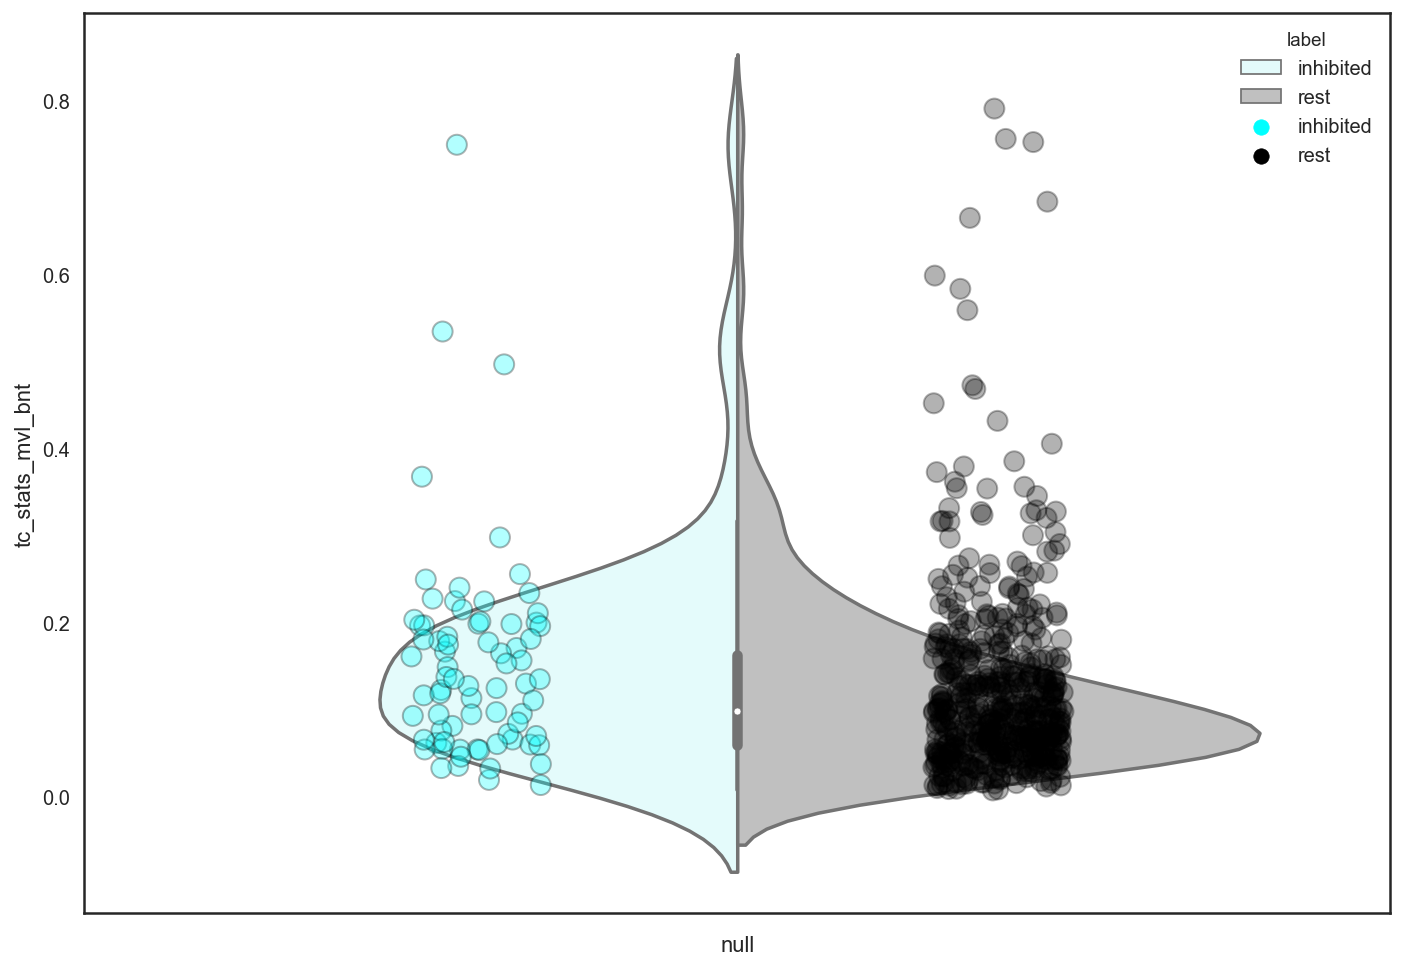

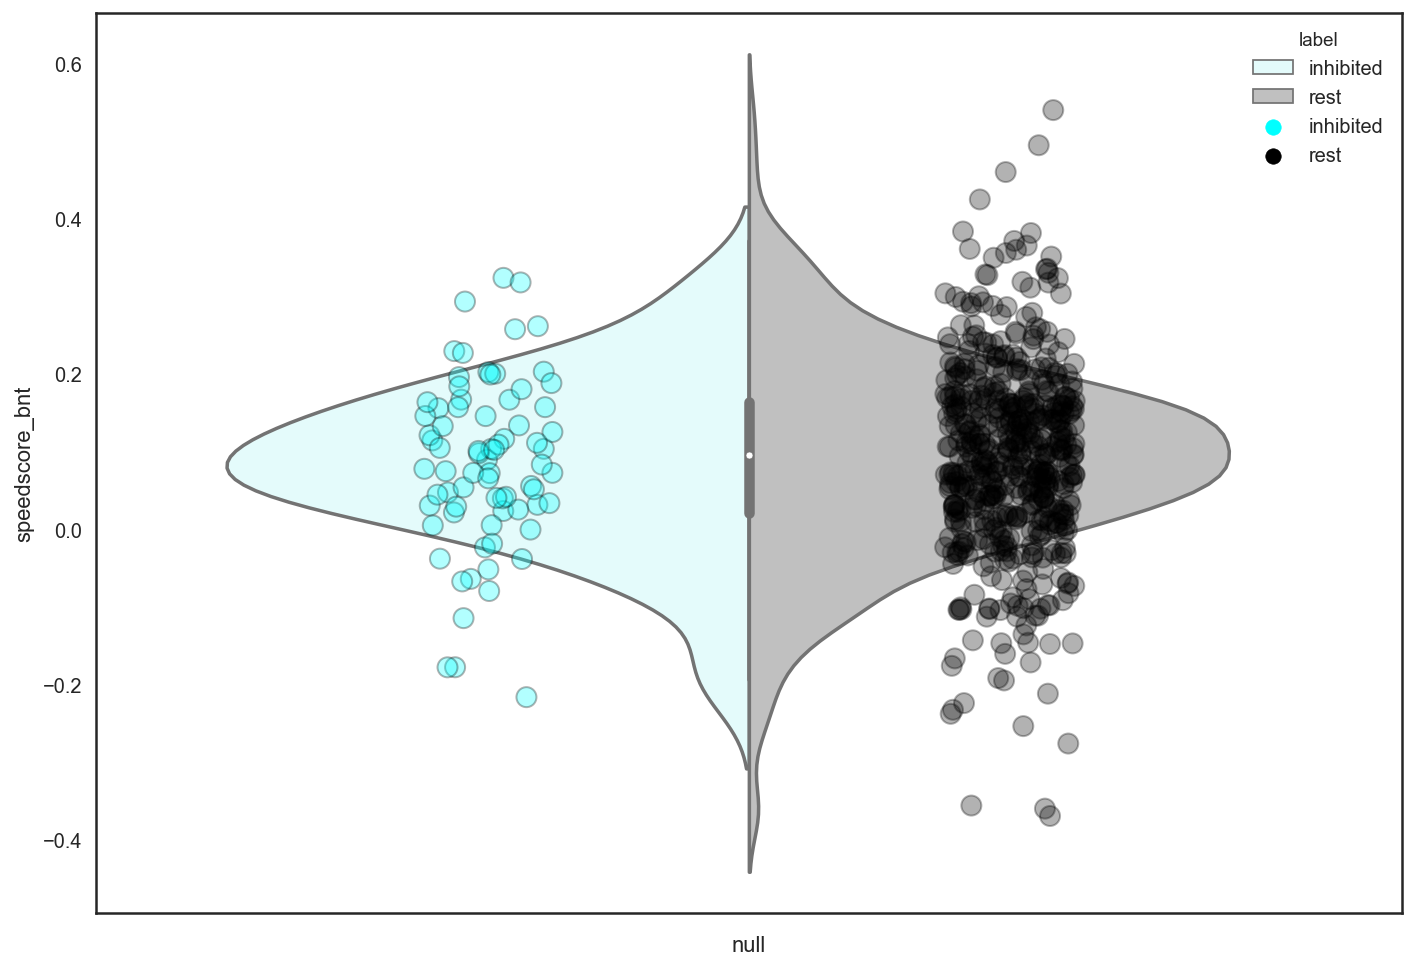

In [93]:
figure = plt.figure(facecolor='w')

sns.set(font_scale=1.)
sns.set_style('white')
 
    

figure.set_size_inches(11.7, 8.27)

sns.set_style("white")

arch_all["null"] = ""

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
#sns.palplot(sns.color_palette())

ax = sns.violinplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3 )
plt.savefig(r'N:\davidcr\stellate paper images\python output\HD_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10, linewidth=1, alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_violin.svg', format='svg', dpi=1000)



## Now check classifier perfomance on tagged cells (related to figure S4)

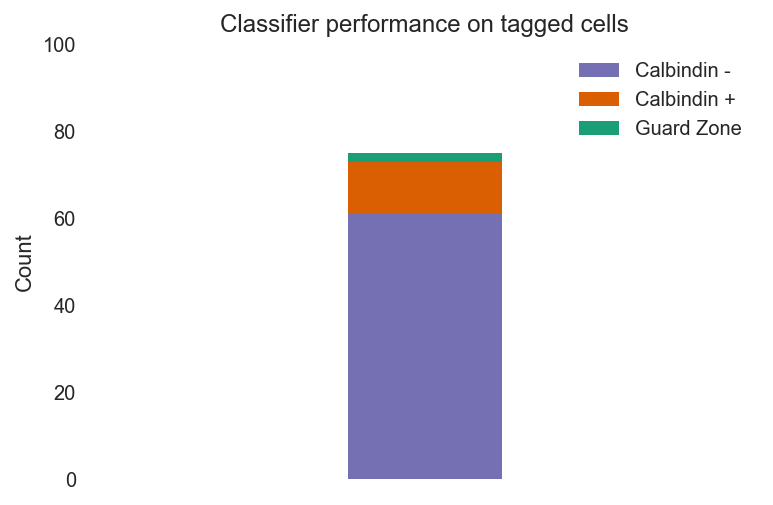

12
2
61


In [94]:
# retrieve tagged cells again
cells = arch_all[(arch_all.label == 'inhibited')].copy()
# get 3 different sets: 
figure.set_size_inches(11.7, 8.27)
calbindin = cells[(cells.calbindin_bnt == 1)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
stellate = cells[(cells.calbindin_bnt == 0)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
rest =cells[np.fabs(cells.calbindin_dist_bnt_single)<0.1]
cb = len(calbindin)
st = len(stellate)
r = len(rest)
width = 0.23
ind = 1
p1 = plt.bar(ind, st, width, color='#7570b3')
p2 = plt.bar(ind, cb, width, color='#d95f02', bottom=st)
p3 = plt.bar(ind, r,width,color='#1b9e77',bottom=[cb+st])


plt.gca().get_xaxis().set_ticks([])

plt.legend((p1[0], p2[0],p3[0]), ('Calbindin -', 'Calbindin +', 'Guard Zone'))
plt.ylim(0,100)
plt.xlim(0.5,1.5)
plt.title('Classifier performance on tagged cells')
plt.ylabel('Count')
sns.despine(left=True,bottom=True)
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_classifier.svg', format='svg', dpi=1000)
plt.show()
print(len(calbindin))
print(len(rest))
print(len(stellate))

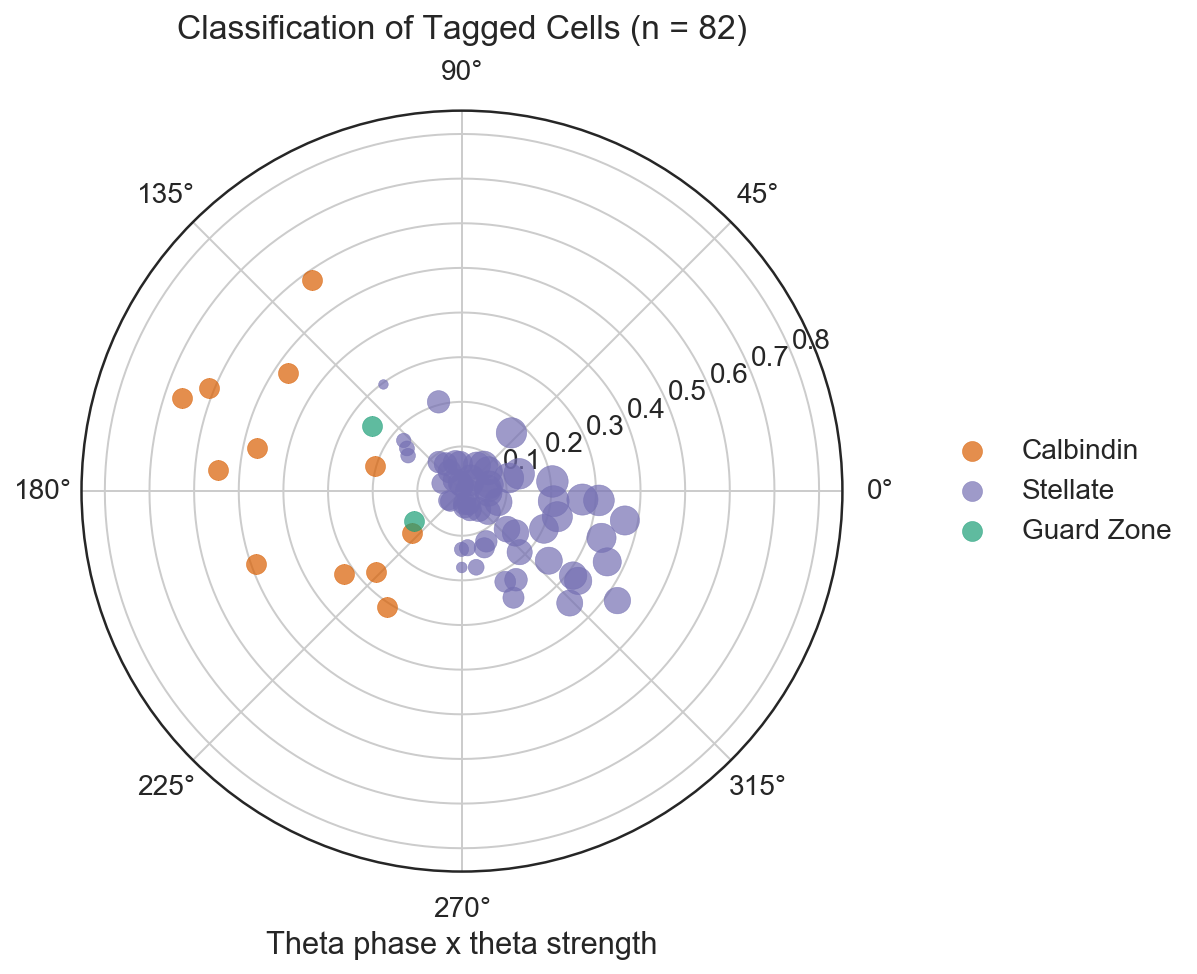

In [95]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s = 100)
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(stellate.calbindin_dist_bnt_single*200).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s = 100)
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 82)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength all tagged.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


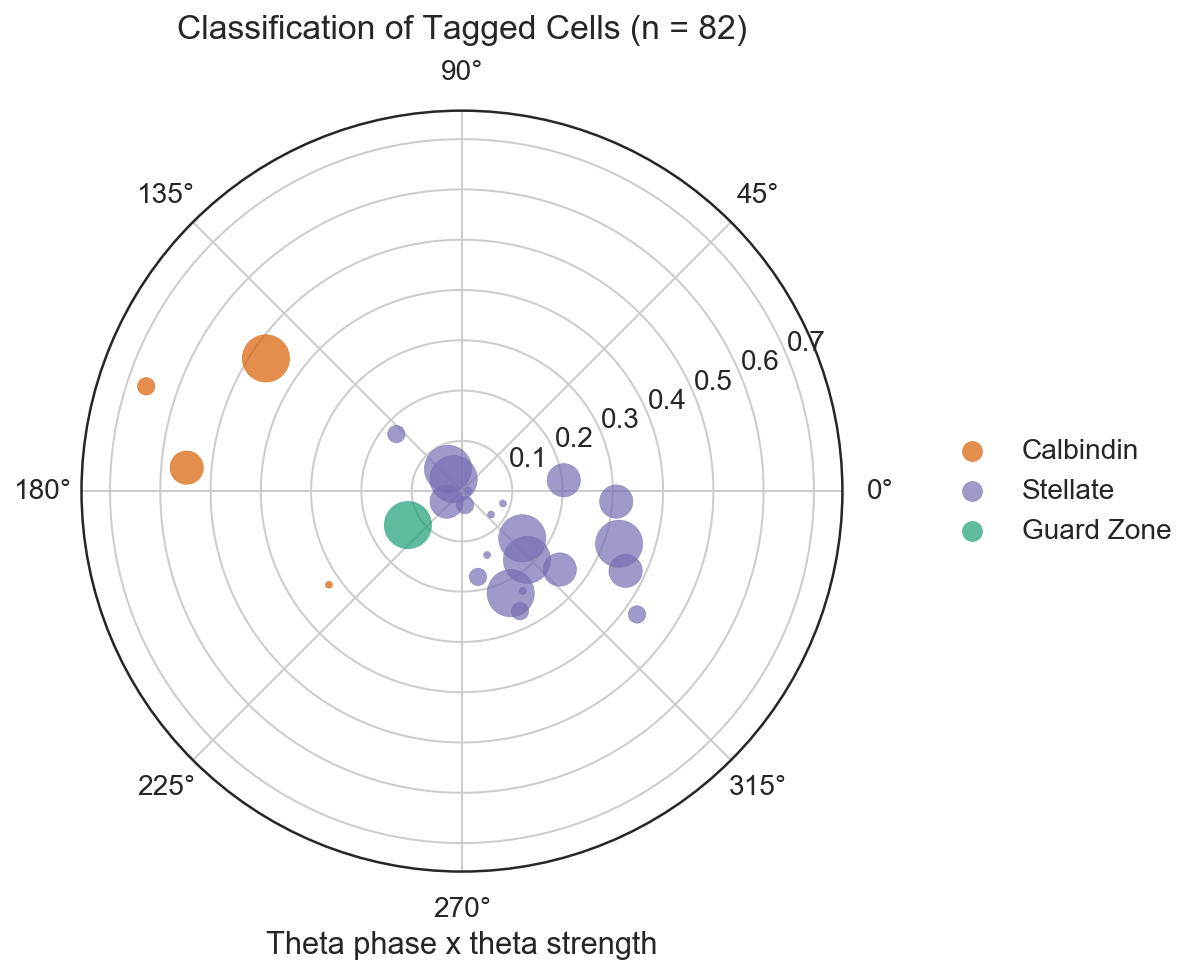

In [96]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s=(calbindin.grid_score_bnt*500).astype(int))
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 82)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength by grid score.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

In [97]:
#test how far the cells were away from the decision boundary...the idea here is to get a quantitative measure of what you can see be eye: the cells aren't to the decision boundary and it is unlikely that the 
#results will change if 

np.mean(calbindin.calbindin_dist_bnt)

-0.86700856085175004

###### psql = psql_neuroballs(arch_all) # initialize retrieval
dict_ = {'BNT_tb_iso':('lratio','isodist')}
filter_ = "NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%rest%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

arch_all = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)
ax = sns.violinplot(x = arch_all["null"],y=arch_all.lratio.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = arch_all["null"],y=arch_all.lratio.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.show()

ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.isodist.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.isodist.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.ylim(0,50)
plt.show()

###### scipy.stats.mannwhitneyu(cells[cells.artefact==0].isodist, non_inhib_cells[non_inhib_cells.artefact==0].isodist)

###### np.mean(non_inhib_cells.isodist)

###### scipy.stats.mannwhitneyu(cells[cells.artefact==0].theta_strength_bnt_single, non_inhib_cells[non_inhib_cells.artefact==0].burst_idx2)

###### plt.show()

###### plt.scatter(non_inhib_cells[non_inhib_cells.artefact==0].grid_score_bnt,non_inhib_cells[non_inhib_cells.artefact==0].isodist)
plt.ylim(0,50)
plt.show()
